In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import deepcopy
import subprocess
import rasterio
from rasterio.plot import show
import geopandas as gpd
from funcs import *
from scipy.ndimage import zoom
from sklearn.metrics import mean_squared_error
from rasterio import mask as msk
import pandas as pd
import scipy.io
from model import *

In [10]:
    #with rasterio.Env():
    destination = np.zeros((np.shape(thk_in)[0], np.shape(thk_in)[1]+3))
    test = rasterio.warp.reproject(
        thk_in,
        destination,
        src_transform=thk_o.transform,
        src_crs=thk_o.crs,
        dst_transform=data.NPI_DEM_o.transform,
        dst_crs=data.NPI_DEM_o.crs,
        resampling=rasterio.warp.Resampling.nearest)

In [2]:
with open('./auto_data/Kronebreen_auto_1420_it_parameters.p_friction_1000_it_fields.vel_mes_it_parameters.pmax_4996__0.pkl', 'rb') as inp:
    md = pickle.load(inp)

In [3]:
print(md.warnings)

[]


Text(0.5, 1.0, 'Bed deviation compared to initial bed vs iter')

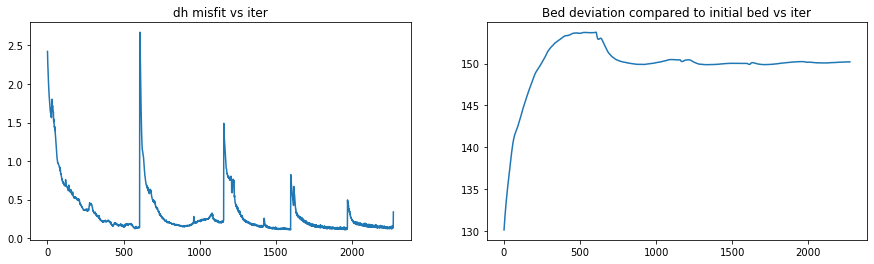

In [6]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
line = ax[0].plot(md.series.dh_misfit_vs_iter)
line = ax[1].plot(abs(np.array(md.series.B_misfit_vs_iter)))
ax[0].set_title('dh misfit vs iter')
ax[1].set_title('Bed deviation compared to initial bed vs iter')
#ax[0].set_ylim([0,5])

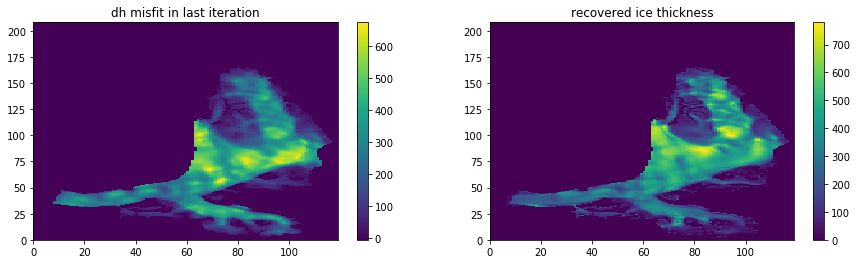

In [29]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
#field = ax[0].pcolor(md.series.misfit_all[-1]*md.it_fields.mask, vmin = -1, vmax = 1, cmap='RdBu')
field = ax[0].pcolor(thk*md.it_fields.mask)
field1 = ax[1].pcolor(md.it_fields.S_ref-md.series.B_rec_all[-1])
ax[0].set_title('dh misfit in last iteration')
ax[1].set_title('recovered ice thickness')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

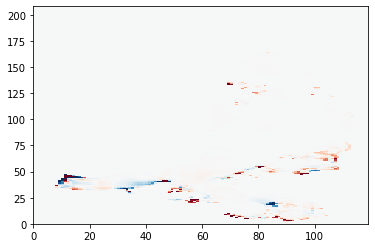

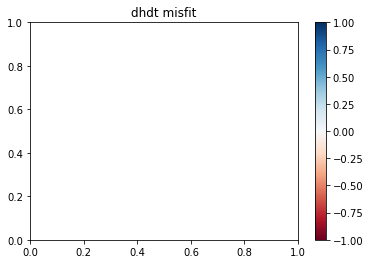

In [43]:
from IPython.display import display, clear_output #needed for animated plots

fig, axes = plt.subplots()
for i in range(0,len(md.series.B_rec_all),50):
    field = axes.pcolor(md.series.misfit_all[i], cmap='RdBu', vmin=-1, vmax=1)
    #field = axes.pcolor(md.series.S_rec_all[i]-md.series.B_rec_all[i], vmax=800, vmin=0)
    clear_output(wait=True)
    display(fig)
    axes.cla()
axes.set_title('dhdt misfit')
fig.colorbar(field)

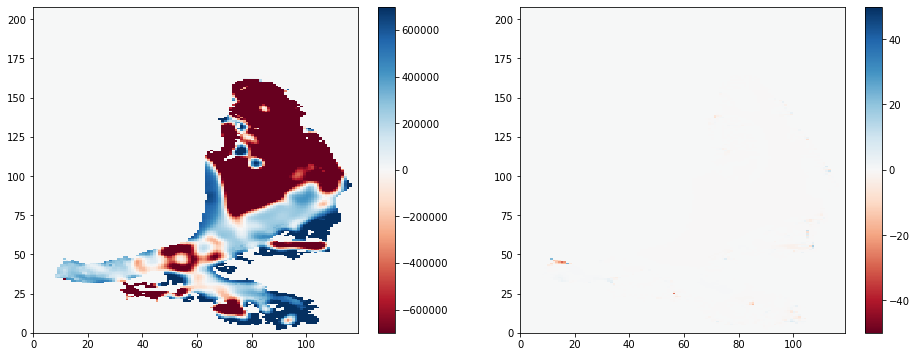

In [7]:
nc_field = 'velsurf_mag'
fig, ax = plt.subplots(1,2,figsize = (16,6))
field = ax[0].pcolor((md.series.tauc_recs[0]-md.series.tauc_recs[-1])*data.mask_Kr, vmin = -7e5, vmax = 7e5, cmap='RdBu')
#field1 = ax[1].pcolor((md.it_products.vel_mismatch)*data.mask_Kr, cmap='RdBu', vmin = -.5, vmax=.5)
field1 = ax[1].pcolor((md.series.B_rec_all[-1] - md.series.B_rec_all[-350])*data.mask_Kr,cmap='RdBu', vmin = -50, vmax=50)
#field1 = ax[1].pcolor((bla)*np.minimum(md.it_fields.vel_mes,1)*md.it_fields.mask, cmap='RdBu', vmin = -.5, vmax=.5)
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

/home/thomas/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


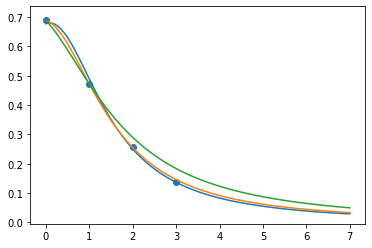

In [14]:
poly1 = np.poly1d(np.polyfit(range(4),1/np.array(mis_ser)[range(1001,4002,1000)],2))
poly2 = np.poly1d(np.polyfit(range(3),1/np.array(mis_ser)[range(1001,3002,1000)],2))
poly3 = np.poly1d(np.polyfit(range(2),1/np.array(mis_ser)[range(1001,2002,1000)],2))
fit1 = poly1(np.linspace(0,7,100))
fit2 = poly2(np.linspace(0,7,100))
fit3 = poly3(np.linspace(0,7,100))
plt.scatter(range(4),np.array(mis_ser)[range(1001,4002,1000)])
plt.plot(np.linspace(0,7,100), 1/fit1)
plt.plot(np.linspace(0,7,100), 1/fit2)
plt.plot(np.linspace(0,7,100), 1/fit3)

(-0.1, 1.5)

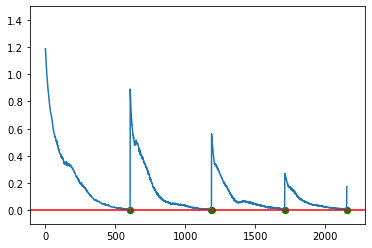

In [10]:
vel_ser = []
mis_ser = []
stop = []
for i in range(len(md.series.B_rec_all)):
    #vel_ser.append(np.median(((md.series.vel_all[i]-md.it_fields.vel_mes)/md.it_fields.vel_mes)[np.logical_and(data.mask_Kr==1, data.x<455000)]))
    mis_ser.append(np.median(abs(md.series.misfit_all[i][data.mask_Kr==1])))
    if i > 20 and np.all(abs(np.array(mis_ser[-20:-1])) < 1e-2):
        stop.append(i)
fig,ax = plt.subplots()
line = ax.plot(mis_ser)
plt.scatter(stop, [0]*len(stop), c='g')
ax.axhline(0, c='r')
ax.set_ylim([-.1,1.5])

(40, 150)

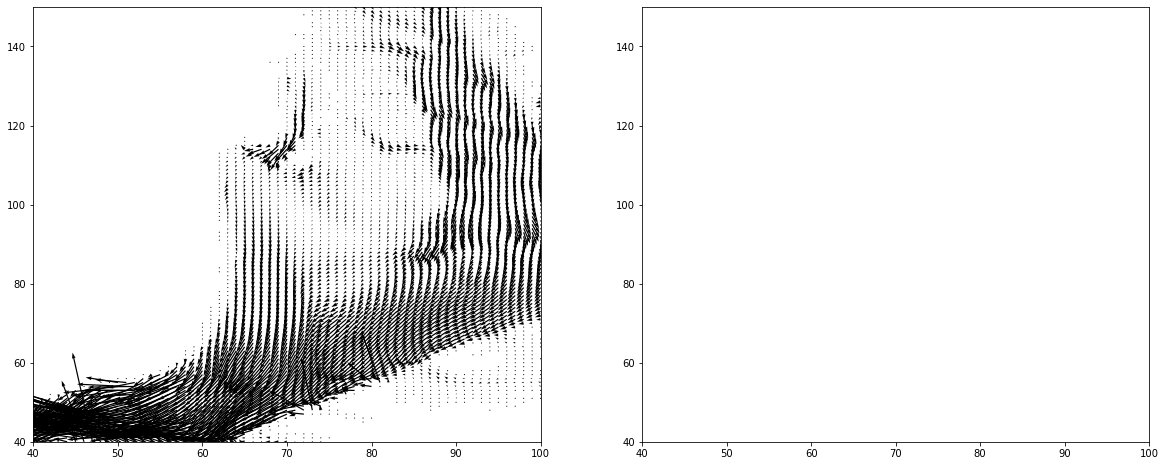

In [59]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
field = ax[0].quiver(md.it_products.u_mod*md.it_fields.mask, md.it_products.v_mod*md.it_fields.mask, scale=2e3)
field1 = ax[1].quiver(data.vx_Adrian, data.vy_Adrian)
ax[0].set_xlim([40,100])
ax[1].set_xlim([40,100])
ax[0].set_ylim([40,150])
ax[1].set_ylim([40,150])

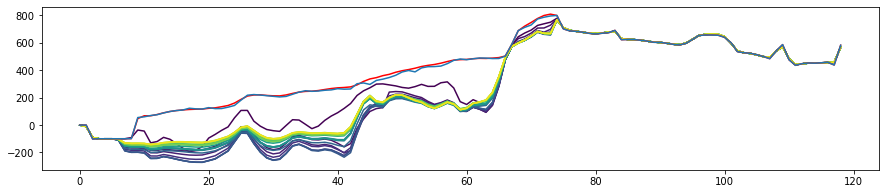

In [11]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(md.series.B_rec_all))]
fig, ax = plt.subplots(figsize=(15,3))
for i in range(0,len(md.series.B_rec_all),100):
    lines = ax.plot(gauss_filter(md.series.B_rec_all[i],.5,3)[40,:], color = colors[i])
lines = ax.plot((md.series.S_rec_all[-1])[40,:], color = 'r')
#line = ax.plot(((md.it_products.h_rec+md.it_fields.B_rec)*md.it_fields.mask)[40,:], 'b')
line = ax.plot((md.it_fields.S_ref)[40,:])

In [ ]:
data = input_data()
data.build_input()

radar = radar_data()
radar.rad_as_array(data)

Text(0.5, 1.0, 'measured vs calculated bed elevation')

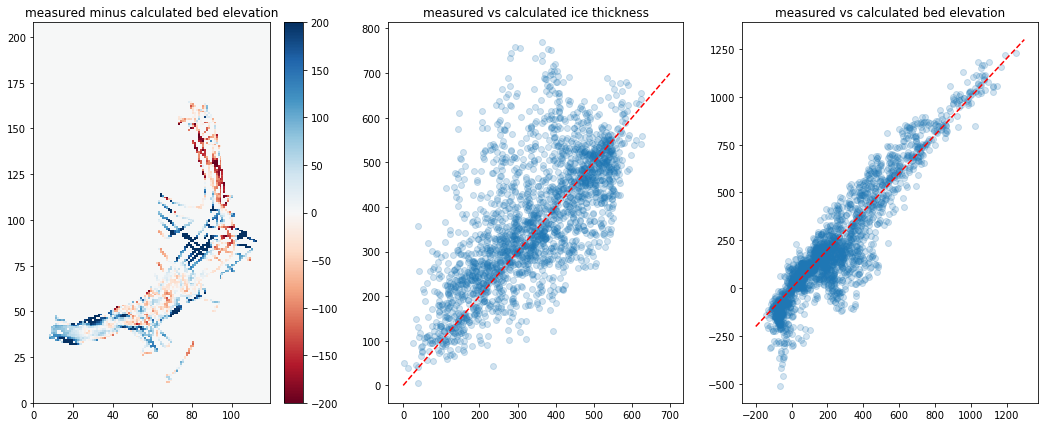

In [7]:
it_step = -1
fig, ax = plt.subplots(1,3, figsize=(18,7))
field = ax[0].pcolor(((md.series.S_rec_all[it_step]-md.series.B_rec_all[it_step])-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask, vmax = 200, vmin = -200, cmap='RdBu')
#field = ax[0].pcolor(((data.thk_Millan)-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask, vmax = 200, vmin = -200, cmap='RdBu')
fig.colorbar(field, ax = ax[0])

line = ax[1].plot(range(700), range(700), '--', c='r')
scatter = ax[1].scatter((md.it_fields.S_ref-radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], (md.series.S_rec_all[it_step]-md.series.B_rec_all[it_step])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2)
#scatter = ax[1].scatter((md.it_fields.S_ref-radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], data.thk_Millan[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2, c='r')

scatter = ax[2].scatter(radar.bed_arr[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], (md.series.B_rec_all[it_step])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2)
line = ax[2].plot(range(-200, 1300), range(-200, 1300), '--', c='r')

ax[0].set_title('measured minus calculated bed elevation')
ax[1].set_title('measured vs calculated ice thickness')
ax[2].set_title('measured vs calculated bed elevation')

In [33]:
test = md.series.S_rec_all[it_step] - md.series.B_rec_all[it_step]
test[md.it_fields.mask==0]=np.nan
test = gauss_filter(test,.6,3)
test[md.it_fields.mask==0]=0

/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


In [8]:
import scipy.stats as st
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
thick_ref_at_rad = (md.it_fields.S_ref - radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
thick_rec_at_rad = (md.series.S_rec_all[it_step] - md.series.B_rec_all[it_step])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
#thick_rec_at_rad = test[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
dev = (thick_rec_at_rad - thick_ref_at_rad)/280
mean_dev = np.nanmean((dev))
mean_abs_dev = np.nanmean(abs(thick_rec_at_rad - thick_ref_at_rad))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
#conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
conf_dev = (np.nanpercentile(dev, 5), np.nanpercentile(dev, 95))
RMSE = math.sqrt(mean_squared_error(thick_ref_at_rad, thick_rec_at_rad))
print('RMSE: {} m'.format(RMSE))
print('mean deviation: {} %'.format(mean_dev))
print('mean absolute deviation: {} m'.format(mean_abs_dev))
print('median deviation: {} %'.format(med_dev))
print('Interquartile range of deviation: {}%'.format(IQR_dev))
print('95% confidence intervall: {}%'.format(conf_dev))

RMSE: 115.05642306772185 m
mean deviation: 0.11107124374774927 %
mean absolute deviation: 82.55323099586111 m
median deviation: 0.060636842237550934 %
Interquartile range of deviation: 0.4113039448197249%
95% confidence intervall: (-0.48507267594610304, 0.8914459879601541)%


In [8]:
dev_all = []
mean_dev_all = []
mean_abs_dev_all = []
med_dev_all = []
IQR_dev_all = []
conf_dev_all = []
RMSE_all = []
thick_ref = (md.it_fields.S_ref - radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
for i in range(len(md.series.B_rec_all)):
    thick_rec = (md.it_fields.S_ref - md.series.B_rec_all[i].data)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
    dev_all.append((thick_rec - thick_ref)/280)
    mean_dev_all.append(np.nanmean((dev_all)))
    mean_abs_dev_all.append(np.nanmean(abs(thick_rec - thick_ref)))
    med_dev_all.append(np.nanmedian(dev_all[i]))
    IQR_dev_all.append(np.nanpercentile(dev_all[i], 75) - np.nanpercentile(dev_all[i], 25))
    conf_dev_all.append(np.nanpercentile(dev_all[i], 95) - np.nanpercentile(dev_all[i], 5))
    RMSE_all.append(math.sqrt(mean_squared_error(thick_ref, thick_rec)))

Text(0.5, 1.0, 'RMSE of deviation')

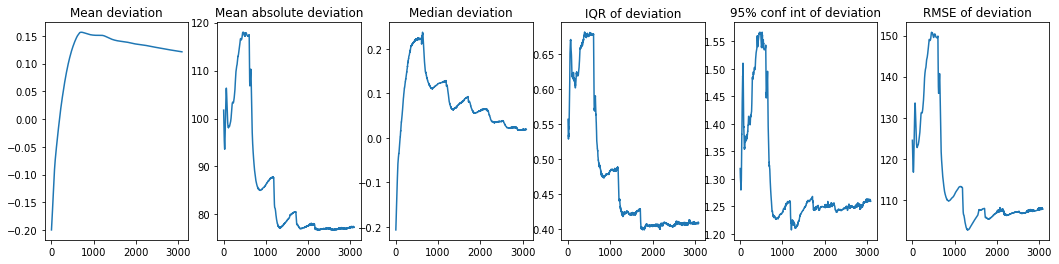

In [9]:
fig, ax = plt.subplots(1,6, figsize=(18,4))
line1 = ax[0].plot(mean_dev_all)
line2 = ax[1].plot(mean_abs_dev_all)
line3 = ax[2].plot(med_dev_all)
line4 = ax[3].plot(IQR_dev_all)
line5 = ax[4].plot(conf_dev_all)
line6 = ax[5].plot(RMSE_all)
ax[0].set_title('Mean deviation')
ax[1].set_title('Mean absolute deviation')
ax[2].set_title('Median deviation')
ax[3].set_title('IQR of deviation')
ax[4].set_title('95% conf int of deviation')
ax[5].set_title('RMSE of deviation')

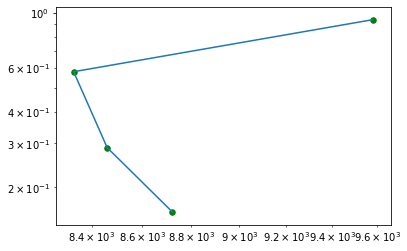

In [162]:
from loess import loess_1d

model_norm = []
residual_norm = []

for i in range(1001,4002,1000):
    model_norm.append(np.sqrt(np.nansum((md.it_fields.B_init - md.series.B_rec_all[i])[md.it_fields.mask==1]**2)))
    residual_norm.append(np.median(abs(md.series.misfit_all[i][md.it_fields.mask==1])))
    
#model_norm = np.convolve(model_norm, np.ones(50)/50)[50:-50]
#residual_norm = np.convolve(residual_norm, np.ones(50)/50)[50:-50]
model_norm_l, residual_norm_l, rest_l = loess_1d.loess_1d(np.array(model_norm), np.array(residual_norm), degree=1, frac = 0.4)
fig, ax = plt.subplots()
line = plt.loglog(model_norm_l, residual_norm_l)
point = ax.scatter(model_norm, residual_norm, s = 30, c='g')
ax.set_yscale('log')
ax.set_xscale('log')

Text(0.5, 1.0, 'percent deviation relative to stake velocities between stake and ITS_LIVE velocities')

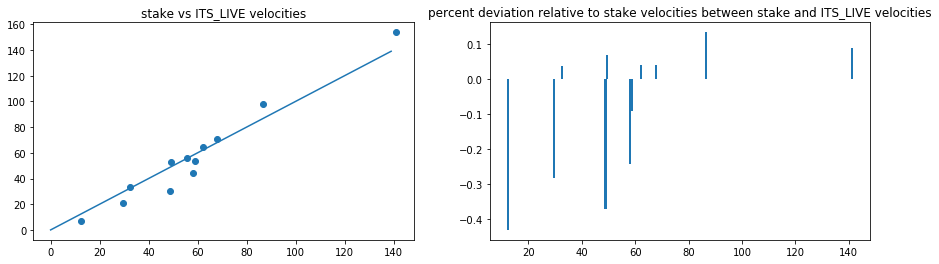

In [13]:
### velocity from Jack ###
vel_xyz_df = pd.read_excel('./kronebreen/HDF_stake_velocities.xlsx', 1, header=None)
vel_x = np.array(vel_xyz_df.loc[:,1])
vel_y = np.array(vel_xyz_df.loc[:,2])
vel_z = np.array(vel_xyz_df.loc[:,3])

vel_df = pd.read_excel('./kronebreen/HDF_stake_velocities.xlsx', 0, header=None)
vel_1420 = np.nanmean(np.array(vel_df.loc[3:,range(20,30,2)]), axis=1)
vel_mes_at_stakes = get_nearest(data.x,data.y,data.vel_Jack, vel_x, vel_y)
fig,ax = plt.subplots(1,2, figsize = (15,4))
points = ax[0].scatter(vel_1420, vel_mes_at_stakes)
line = ax[0].plot(range(140), range(140))
points1 = ax[1].bar(vel_1420, (vel_mes_at_stakes  - vel_1420)/vel_1420)

ax[0].set_title('stake vs ITS_LIVE velocities')
ax[1].set_title('percent deviation relative to stake velocities between stake and ITS_LIVE velocities')

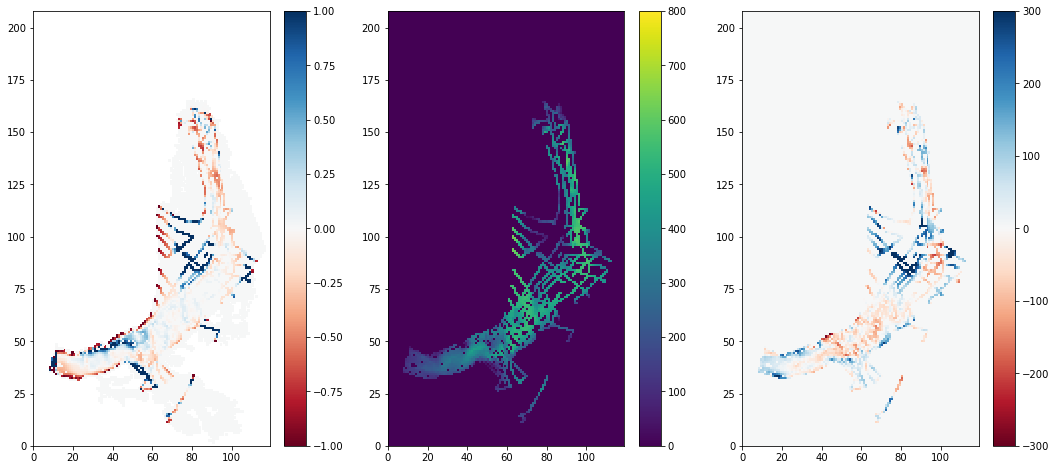

In [15]:
fig,ax = plt.subplots(1,3,figsize = (18,8))
field = ax[0].pcolor((md.series.vel_all[it_step]-data.vel_Millan)/(data.vel_Millan)*radar.mask_arr*np.minimum(md.it_fields.vel_mes,1), cmap = 'RdBu', vmin = -1, vmax = 1)
field1 = ax[1].pcolor((md.it_fields.S_ref - radar.bed_arr)*radar.mask_arr*md.it_fields.mask, vmax = 800, vmin = 0)
field2 = ax[2].pcolor(((md.it_fields.S_rec - md.it_fields.B_rec)-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask, vmax = 300, vmin = -300, cmap='RdBu')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])
fig.colorbar(field2, ax = ax[2])

In [34]:
vel = ((md.series.vel_all[it_step]-md.it_fields.vel_mes))[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
rad = ((md.it_fields.S_ref-radar.bed_arr) - (md.it_fields.S_ref-md.series.B_rec_all[it_step]))[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
flow = abs(np.degrees(flow_dir_diff[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]))

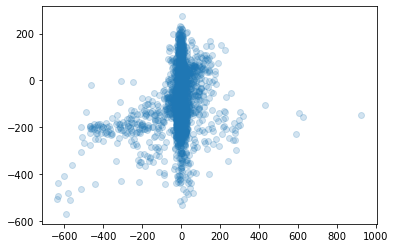

In [36]:
fig, ax = plt.subplots()
points = ax.scatter(vel,rad, alpha=.2)
#ax.set_xlim([0,2])
#ax.set_ylim([0,30])

In [27]:
y_sub, x_sub = np.ogrid[:np.shape(md.it_fields.S_ref)[0]/4,:np.shape(md.it_fields.S_ref)[1]/4]
y_sub *= 4
x_sub *= 4
x_sub = zoom(data.x, .25)
y_sub = zoom(data.y, .25)
thick_ref = (scipy.interpolate.griddata((radar.x_arr[radar.mask_arr==1].flatten() , radar.y_arr[radar.mask_arr==1].flatten()), (md.it_fields.S_ref - radar.bed_arr)[radar.mask_arr==1].flatten(), (zoom(data.x, 1).flatten(), zoom(data.y, 1).flatten()))).reshape(np.shape(zoom(data.x, 1)))
#thick_ref[np.isnan(thick_ref)] = 0
#thick_ref = zoom(thick_ref, 4)[:,:119]
#thick_ref[thick_ref<10] = np.nan
#plt.scatter(x_sub, y_sub, c = np.unique(radar_sub))
#scripy.interpolate.griddata()

In [28]:
import scipy.stats as st
thick_rec = (md.it_fields.S_rec - md.it_fields.B_rec)
dev = ((thick_rec - thick_ref)/np.nanmean(thick_ref))[np.logical_and(data.mask_Kr==1, thick_rec!=0)]
mean_dev = np.nanmean((dev))
mean_abs_dev = np.nanmean(abs(thick_rec - thick_ref)[np.logical_and(data.mask_Kr==1, thick_rec!=0)])
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
#conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
conf_dev = (np.nanpercentile(dev, 5), np.nanpercentile(dev, 95))
RMSE = math.sqrt(mean_squared_error(thick_ref[np.logical_and(np.logical_and(data.mask_Kr==1, thick_rec!=0), np.isnan(thick_ref)==False)], thick_rec[np.logical_and(np.logical_and(data.mask_Kr==1, thick_rec!=0), np.isnan(thick_ref)==False)]))
print('RMSE: {} m'.format(RMSE))
print('mean deviation: {} %'.format(mean_dev))
print('mean absolute deviation: {} m'.format(mean_abs_dev))
print('median deviation: {} %'.format(med_dev))
print('Interquartile range of deviation: {}%'.format(IQR_dev))
print('95% confidence intervall: {}%'.format(conf_dev))

RMSE: 142.14496189295076 m
mean deviation: 0.09242059167900206 %
mean absolute deviation: 112.3093976872027 m
median deviation: 0.09115346939955793 %
Interquartile range of deviation: 0.6099245785795996%
95% confidence intervall: (-0.7322478088420207, 0.8448280830089904)%


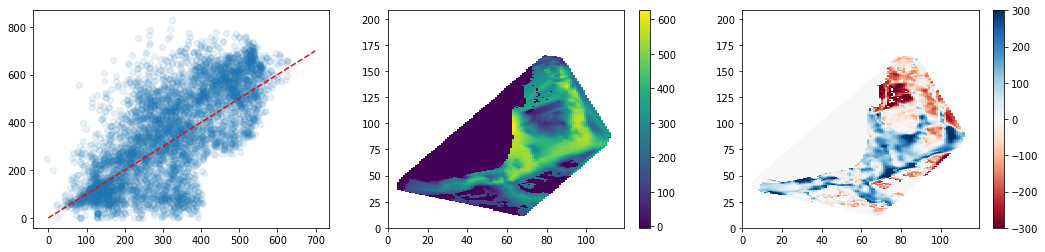

In [29]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
points = ax[0].scatter(thick_ref[np.logical_and(data.mask_Kr==1, thick_rec!=0)], (md.it_fields.S_rec - md.it_fields.B_rec)[np.logical_and(data.mask_Kr==1, thick_rec!=0)], alpha=0.1)
line = ax[0].plot(range(700), range(700), '--',c='r')
field = ax[1].pcolor(thick_ref*data.mask_Kr)
field1 = ax[2].pcolor((thick_rec - thick_ref)*data.mask_Kr, cmap='RdBu', vmin = -300, vmax = 300)
fig.colorbar(field, ax = ax[1])
fig.colorbar(field1, ax = ax[2])

In [3]:
data = input_data()
data.build_input()

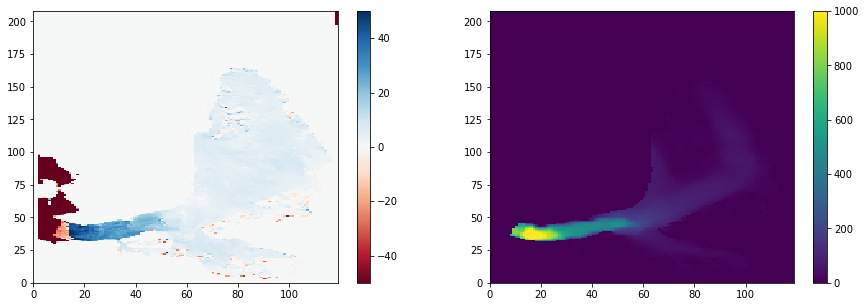

In [11]:
#u = md.it_products.u_mod
#v = md.it_products.v_mod
#vel = md.it_products.vel_mod

fig, ax = plt.subplots(1,2, figsize=(15,5))
field = ax[0].pcolor(md.it_fields.S_ref-data.dhdt1, vmin = -50, vmax=50, cmap='RdBu')
field1= ax[1].pcolor(data.vel_Jack*data.mask, vmin = 0, vmax = 1e3)
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

In [2]:
data = input_data()
data.build_input()
md = model(data)
md.it_parameters.pmax=900
md.it_fields.vel_mes = data.vel_Jack
md.it_parameters.p_friction = 700
md.iterate(data)

/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


0


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


1


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


2


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


3


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


4


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


5


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


6


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


7


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


8


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


9


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


10


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


11


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


12


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


13


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


14


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


15


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


16


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


17


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


18


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


19


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


20


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


21


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


22


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


23


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


24


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


25


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


26


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


27


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


28


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


29


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


30


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


31


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


32


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


33


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


34


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


35


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


36


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


37


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


38


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


39


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


40


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


41


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


42


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


43


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


44


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


45


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


46


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


47


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


48


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


49


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


50


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


51


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


52


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


53


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


54


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


55


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


56


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


57


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


58


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


59


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


60


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


61


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


62


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


63


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


64


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


65


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


66


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


67


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


68


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


69


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


70


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


71


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


72


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


73


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


74


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


75


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


76


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


77


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


78


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


79


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


80


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


81


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


82


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


83


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


84


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


85


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


86


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


87


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


88


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


89


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


90


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


91


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


92


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


93


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


94


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


95


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


96


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


97


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


98


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


99


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


100


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


101


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


102


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


103


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


104


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


105


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


106


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


107


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


108


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


109


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


110


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


111


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


112


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


113


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


114


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


115


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


116


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


117


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


118


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


119


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


120


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


121


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


122


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


123


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


124


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


125


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


126


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


127


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


128


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


129


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


130


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


131


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


132


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


133


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


134


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


135


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


136


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


137


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


138


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


139


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


140


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


141


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


142


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


143


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


144


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


145


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


146


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


147


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


148


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


149


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


150


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


151


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


152


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


153


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


154


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


155


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


156


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


157


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


158


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


159


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


160


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


161


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


162


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


163


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


164


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


165


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


166


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


167


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


168


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


169


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


170


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


171


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


172


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


173


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


174


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


175


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


176


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


177


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


178


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


179


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


180


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


181


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


182


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


183


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


184


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


185


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


186


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


187


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


188


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


189


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


190


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


191


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


192


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


193


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


194


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


195


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


196


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


197


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


198


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


199


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


200


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


201


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


202


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


203


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


204


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


205


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


206


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


207


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


208


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


209


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


210


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


211


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


212


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


213


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


214


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


215


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


216


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


217


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


218


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


219


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


220


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


221


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


222


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


223


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


224


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


225


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


226


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


227


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


228


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


229


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


230


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


231


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


232


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


233


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


234


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


235


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


236


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


237


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


238


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


239


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


240


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


241


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


242


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


243


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


244


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


245


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


246


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


247


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


248


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


249


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


250


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


251


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


252


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


253


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


254


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


255


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


256


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


257


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


258


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


259


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


260


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


261


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


262


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


263


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


264


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


265


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


266


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


267


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


268


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


269


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


270


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


271


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


272


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


273


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


274


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


275


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


276


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


277


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


278


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


279


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


280


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


281


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


282


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


283


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


284


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


285


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


286


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


287


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


288


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


289


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


290


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


291


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


292


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


293


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


294


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


295


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


296


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


297


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


298


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


299


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


300


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


301


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


302


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


303


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


304


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


305


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


306


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


307


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


308


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


309


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


310


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


311


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


312


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


313


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


314


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


315


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


316


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


317


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


318


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


319


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


320


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


321


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


322


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


323


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


324


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


325


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


326


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


327


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


328


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


329


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


330


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


331


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


332


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


333


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


334


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


335


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


336


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


337


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


338


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


339


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


340


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


341


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


342


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


343


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


344


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


345


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


346


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


347


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


348


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


349


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


350


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


351


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


352


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


353


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


354


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


355


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


356


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


357


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


358


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


359


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


360


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


361


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


362


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


363


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


364


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


365


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


366


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


367


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


368


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


369


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


370


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


371


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


372


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


373


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


374


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


375


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


376


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


377


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


378


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


379


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


380


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


381


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


382


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


383


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


384


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


385


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


386


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


387


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


388


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


389


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


390


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


391


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


392


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


393


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


394


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


395


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


396


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


397


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


398


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


399


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


400


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


401


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


402


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


403


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


404


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


405


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


406


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


407


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


408


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


409


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


410


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


411


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


412


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


413


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


414


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


415


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


416


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


417


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


418


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


419


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


420


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


421


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


422


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


423


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


424


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


425


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


426


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


427


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


428


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


429


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


430


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


431


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


432


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


433


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


434


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


435


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


436


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


437


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


438


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


439


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


440


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


441


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


442


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


443


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


444


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


445


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


446


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


447


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


448


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


449


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


450


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


451


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


452


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


453


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


454


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


455


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


456


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


457


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


458


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data
/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


459


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data
/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


In [10]:
#ref_file = './auto_ncs/KK_auto_reference_it490.nc'
#md.series.S_rec_all.append(get_nc_data(ref_file, 'usurf', 0))
#md.series.B_rec_all.append(get_nc_data(ref_file, 'topg', 0))
#md.series.tauc_recs.append(get_nc_data(ref_file, 'tauc', 0))
#md.series.B_rec_all[-1] = np.minimum(md.series.B_rec_all[-1], md.series.S_rec_all[-1])
#md.it_fields.vel_mes = data.vel_Adrian
md.it_parameters.p_friction = 30
md.it_parameters.pmax= 50
#md.series.B_rec_all[450] = np.minimum(md.series.B_rec_all[450], md.series.S_rec_all[-1])
md.restart(-1)
md.it_parameters.p_friction = 500
md.it_parameters.pmax = 1000
md.restart(-1)
#md.it_parameters.p_friction = 3000
#md.it_parameters.pmax = 300
#md.restart(-1)

0


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


1


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


2


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


3


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


4


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


5


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


6


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


7


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


8


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


9


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


10


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


11


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


12


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


13


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


14


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


15


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


16


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


17


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


18


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


19


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


20


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


21


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


22


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


23


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


24


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


25


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


26


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


27


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


28


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


29


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


30


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data
/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


31


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


32


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


33


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


34


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


35


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


36


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


37


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


38


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


39


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


40


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


41


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


42


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


43


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


44


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


45


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


46


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


47


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


48


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


49


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


0


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


1


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


2


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


3


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


4


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


5


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


6


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


7


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


8


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


9


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


10


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


11


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


12


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


13


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


14


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


15


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


16


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


17


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


18


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


19


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


20


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


21


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


22


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


23


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


24


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


25


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


26


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


27


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


28


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


29


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


30


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


31


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


32


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


33


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


34


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


35


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


36


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


37


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


38


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


39


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


40


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


41


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


42


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


43


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


44


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


45


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


46


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


47


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


48


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


49


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


50


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


51


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


52


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


53


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


54


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


55


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


56


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


57


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


58


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


59


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


60


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


61


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


62


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


63


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


64


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


65


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


66


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


67


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


68


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


69


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


70


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


71


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


72


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


73


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


74


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


75


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


76


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


77


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


78


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


79


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


80


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


81


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


82


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


83


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


84


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


85


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


86


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


87


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


88


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


89


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


90


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


91


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


92


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


93


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


94


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


95


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


96


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


97


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


98


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


99


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


100


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


101


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


102


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


103


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


104


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


105


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


106


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


107


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


108


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


109


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


110


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


111


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


112


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


113


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


114


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


115


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


116


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


117


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


118


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


119


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


120


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


121


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


122


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


123


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


124


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


125


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


126


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


127


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


128


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


129


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


130


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


131


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


132


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


133


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


134


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


135


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


136


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


137


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


138


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


139


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


140


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


141


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


142


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


143


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


144


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


145


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


146


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


147


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


148


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


149


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


150


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


151


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


152


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


153


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


154


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


155


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


156


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


157


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


158


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


159


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


160


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


161


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


162


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


163


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


164


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


165


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


166


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


167


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


168


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


169


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


170


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


171


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


172


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


173


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


174


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


175


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


176


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


177


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


178


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


179


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


180


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


181


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


182


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


183


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


184


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


185


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


186


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


187


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


188


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


189


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


190


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


191


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


192


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


193


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


194


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


195


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


196


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


197


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


198


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


199


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


200


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


201


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


202


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


203


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


204


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


205


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


206


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


207


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


208


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


209


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


210


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


211


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


212


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


213


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


214


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


215


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


216


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


217


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


218


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


219


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


220


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


221


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


222


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


223


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


224


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


225


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


226


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


227


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


228


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


229


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


230


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


231


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


232


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


233


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


234


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


235


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


236


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


237


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


238


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


239


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


240


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


241


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


242


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


243


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


244


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


245


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


246


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


247


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


248


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


249


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


250


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


251


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


252


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


253


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


254


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


255


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


256


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


257


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


258


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


259


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


260


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


261


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


262


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


263


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


264


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


265


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


266


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


267


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


268


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


269


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


270


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


271


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


272


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


273


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


274


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


275


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


276


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


277


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


278


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


279


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


280


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


281


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


282


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


283


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


284


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


285


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


286


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


287


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


288


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


289


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


290


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


291


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


292


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


293


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


294


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


295


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


296


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


297


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


298


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


299


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


300


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


301


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


302


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


303


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


304


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


305


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


306


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


307


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


308


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


309


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


310


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


311


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


312


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


313


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


314


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


315


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


316


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


317


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


318


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


319


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


320


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


321


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


322


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


323


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


324


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


325


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


326


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


327


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


328


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


329


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


330


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


331


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


332


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


333


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


334


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


335


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


336


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


337


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


338


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


339


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


340


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


341


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


342


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


343


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


344


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


345


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


346


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


347


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


348


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


349


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


350


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


351


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


352


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


353


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


354


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


355


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


356


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


357


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


358


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


359


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


360


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


361


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


362


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


363


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


364


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


365


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


366


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


367


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


368


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


369


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


370


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


371


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


372


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


373


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


374


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


375


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


376


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


377


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


378


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


379


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


380


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


381


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


382


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


383


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


384


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


385


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


386


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


387


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


388


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


389


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


390


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


391


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


392


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


393


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


394


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


395


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


396


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


397


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


398


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


399


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


400


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


401


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


402


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


403


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


404


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


405


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


406


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


407


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


408


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


409


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


410


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


411


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


412


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


413


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


414


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


415


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


416


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


417


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


418


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


419


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


420


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


421


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


422


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


423


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


424


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


425


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


426


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


427


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


428


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


429


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


430


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


431


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


432


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


433


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


434


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


435


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


436


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


437


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


438


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


439


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


440


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


441


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


442


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


443


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


444


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


445


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


446


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


447


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


448


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


449


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


450


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


451


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


452


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


453


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


454


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


455


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


456


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


457


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


458


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


459


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


460


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


461


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


462


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


463


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


464


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


465


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


466


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


467


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


468


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


469


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


470


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


471


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


472


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


473


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


474


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


475


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


476


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


477


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


478


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


479


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


480


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


481


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


482


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


483


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


484


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


485


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


486


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


487


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


488


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


489


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


490


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


491


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


492


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


493


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


494


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


495


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


496


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


497


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


498


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


499


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


500


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data
/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


501


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


502


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


503


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


504


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


505


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


506


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


507


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


508


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


509


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


510


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


511


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


512


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


513


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


514


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


515


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


516


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


517


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


518


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


519


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


520


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


521


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


522


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


523


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


524


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


525


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


526


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


527


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


528


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


529


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


530


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


531


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


532


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


533


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


534


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


535


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


536


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


537


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


538


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


539


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


540


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


541


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


542


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


543


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


544


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


545


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


546


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


547


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


548


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


549


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


550


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


551


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


552


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


553


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


554


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


555


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


556


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


557


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


558


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


559


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


560


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


561


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


562


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


563


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


564


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


565


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


566


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


567


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


568


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


569


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


570


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


571


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


572


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


573


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


574


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


575


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


576


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


577


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


578


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


579


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


580


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


581


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


582


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


583


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


584


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


585


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


586


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


587


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


588


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


589


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


590


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


591


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


592


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


593


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


594


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


595


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


596


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


597


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


598


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


599


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


600


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


601


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


602


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


603


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


604


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


605


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


606


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


607


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


608


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


609


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


610


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


611


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


612


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


613


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


614


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


615


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


616


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


617


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


618


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


619


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


620


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


621


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


622


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


623


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


624


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


625


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


626


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


627


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


628


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


629


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


630


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


631


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


632


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


633


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


634


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


635


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


636


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


637


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


638


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


639


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


640


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


641


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


642


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


643


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


644


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


645


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


646


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


647


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


648


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


649


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


650


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


651


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


652


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


653


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


654


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


655


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


656


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


657


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


658


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


659


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


660


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


661


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


662


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


663


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


664


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


665


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


666


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


667


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


668


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


669


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


670


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


671


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


672


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


673


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


674


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


675


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


676


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


677


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


678


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


679


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


680


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


681


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


682


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


683


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


684


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


685


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


686


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


687


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


688


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


689


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


690


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


691


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


692


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


693


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


694


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


695


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


696


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


697


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


698


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


699


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


700


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


701


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


702


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


703


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


704


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


705


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


706


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


707


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


708


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


709


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


710


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


711


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


712


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


713


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


714


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


715


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


716


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


717


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


718


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


719


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


720


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


721


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


722


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


723


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


724


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


725


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


726


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


727


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


728


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


729


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


730


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


731


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


732


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


733


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


734


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


735


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


736


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


737


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


738


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


739


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


740


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


741


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


742


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


743


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


744


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


745


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


746


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


747


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


748


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


749


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


750


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


751


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


752


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


753


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


754


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


755


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


756


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


757


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


758


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


759


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


760


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


761


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


762


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


763


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


764


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


765


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


766


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


767


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


768


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


769


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


770


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


771


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


772


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


773


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


774


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


775


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


776


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


777


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


778


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


779


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


780


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


781


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


782


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


783


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


784


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


785


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


786


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


787


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


788


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


789


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


790


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


791


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


792


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


793


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


794


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


795


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


796


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


797


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


798


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


799


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


800


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


801


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


802


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


803


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


804


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


805


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


806


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


807


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


808


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


809


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


810


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


811


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


812


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


813


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


814


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


815


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


816


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


817


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


818


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


819


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


820


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


821


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


822


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


823


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


824


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


825


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


826


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


827


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


828


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


829


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


830


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


831


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


832


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


833


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


834


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


835


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


836


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


837


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


838


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


839


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


840


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


841


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


842


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


843


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


844


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


845


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


846


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


847


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


848


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


849


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


850


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


851


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


852


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


853


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


854


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


855


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


856


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


857


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


858


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


859


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


860


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


861


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


862


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


863


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


864


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


865


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


866


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


867


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


868


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


869


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


870


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


871


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


872


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


873


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


874


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


875


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


876


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


877


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


878


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


879


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


880


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


881


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


882


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


883


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


884


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


885


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


886


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


887


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


888


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


889


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


890


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


891


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


892


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


893


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


894


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


895


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


896


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


897


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


898


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


899


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


900


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


901


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


902


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


903


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


904


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


905


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


906


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


907


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


908


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


909


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


910


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


911


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


912


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


913


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


914


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


915


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


916


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


917


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


918


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


919


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


920


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


921


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


922


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


923


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


924


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


925


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


926


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


927


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


928


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


929


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


930


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


931


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


932


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


933


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


934


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


935


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


936


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


937


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


938


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


939


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


940


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


941


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


942


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


943


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


944


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


945


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


946


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


947


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


948


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


949


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


950


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


951


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


952


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


953


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


954


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


955


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


956


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


957


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


958


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


959


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


960


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


961


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


962


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


963


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


964


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


965


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


966


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


967


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


968


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


969


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


970


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


971


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


972


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


973


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


974


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


975


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


976


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


977


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


978


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


979


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


980


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


981


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


982


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


983


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


984


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


985


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


986


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


987


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


988


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


989


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


990


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


991


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


992


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


993


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


994


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


995


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


996


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


997


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


998


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


999


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


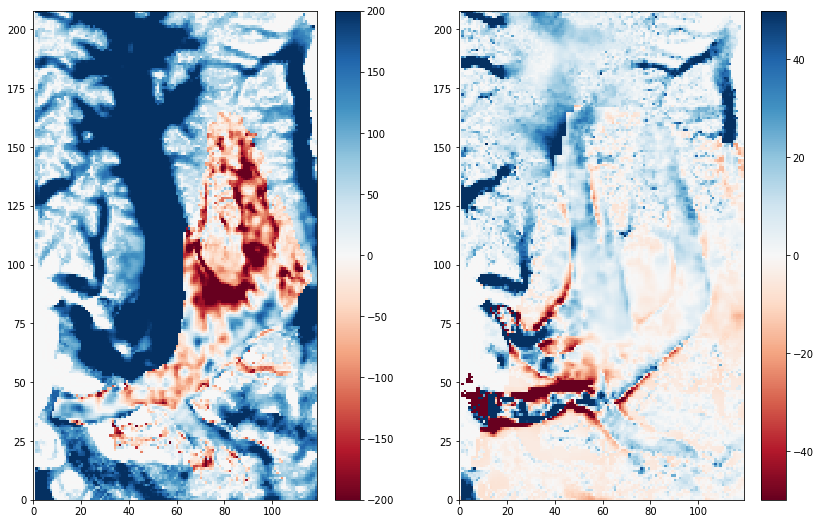

In [61]:
fig,ax = plt.subplots(1,2, figsize = (14,9))
field = ax[0].pcolor(thk - (md.it_fields.S_rec-md.it_fields.B_rec)*md.it_fields.mask, vmax =-200, vmin = 200, cmap='RdBu')
field1 = ax[1].pcolor(vel - data.vel_Jack, vmax =-50, vmin = 50, cmap='RdBu')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

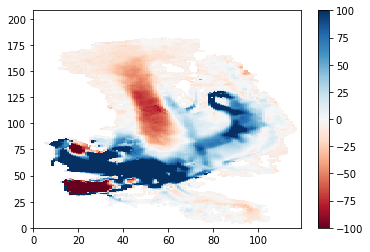

In [8]:
fig, ax = plt.subplots()
#field = ax.pcolor(get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'velsurf_mag',0),vmax=1000)
field = ax.pcolor(md.it_products.vel_mod-data.vel_Adrian, cmap = 'RdBu', vmin = -100, vmax = 100)
fig.colorbar(field, ax = ax)

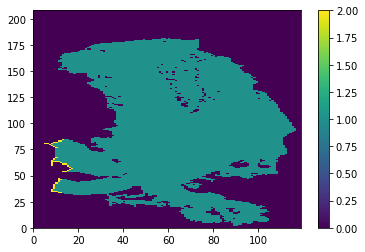

In [4]:
fig,ax = plt.subplots()
field = ax.pcolor(data.mask+data.contact_zone)#, vmin = 0, vmax = 90)
fig.colorbar(field, ax = ax)

In [26]:
data1 = input_data()
DEM_VEL_mat = scipy.io.loadmat('./kronebreen/HDF_2021_10_06.mat')['HDF'][0,0]
data1.set_xy(DEM_VEL_mat)
data1.reset_shape()
data1.import_NPI_DEM("./kronebreen/S0_DTM50.tif")
data1.get_vel(DEM_VEL_mat)
data1.get_outlines('./kronebreen/rgi_outlines/07_rgi60_Svalbard.shp')
data1.get_dhdt(DEM_VEL_mat)
data1.get_mask()
#data1.clean_dhdt()
data1.get_vel_Adrian()
#data1.resample_input()

In [27]:
with rasterio.open('./kronebreen/S0_DTM50.tif') as src:
    profile = src.profile.copy()
    profile1 = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a  * 5, aff.b, aff.c+data.window.col_off*50,
                             aff.d, aff.e * 5, aff.f-data.window.row_off*50)

    newaff1 = rasterio.Affine(aff.a, aff.b, aff.c+data.window.col_off*50,
                             aff.d, aff.e, aff.f-data.window.row_off*50)
    profile.update({
            'dtype': 'float32',
            'height':md.it_fields.B_rec.shape[0],
            'width':md.it_fields.B_rec.shape[1],
            'transform': newaff}) 
    profile1.update({
            'dtype': 'float32',
            'height':data1.mask.shape[0],
            'width':data1.mask.shape[1],
            'transform': newaff1}) 
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/B_rec.tif', 'w', **profile) as dst:
    dst.write_band(1, np.flip(md.it_fields.B_rec, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/dhdt.tif', 'w', **profile) as dst:
    dhdt_mask = np.zeros_like(md.it_fields.S_ref)*np.nan
    dhdt_mask[data.mask_Kr==1] = data.dhdt[data.mask_Kr==1]
    dst.write_band(1, np.flip(dhdt_mask, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/data.mask_Kr.tif', 'w', **profile) as dst:
    dst.write_band(1, np.flip(data.mask_Kr, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/smb.tif', 'w', **profile) as dst:
    smb_mask = np.zeros_like(md.it_fields.S_ref)*np.nan
    smb_mask[data.mask_Kr==1] = md.it_fields.smb[data.mask_Kr==1]
    dst.write_band(1, np.flip(smb_mask, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/thick.tif', 'w', **profile) as dst:
    thick = np.zeros_like(md.it_fields.S_ref)*np.nan
    thick[data.mask_Kr==1] = md.it_fields.S_rec[data.mask_Kr==1] -md.it_fields.B_rec[data.mask_Kr==1]
    dst.write_band(1, np.flip(thick, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Adrian.tif', 'w', **profile) as dst:
    vel_Adrian = data.vel_Adrian
    dst.write_band(1, np.flip(vel_Adrian, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Jack.tif', 'w', **profile) as dst:
    vel_Jack = data.vel_Jack
    dst.write_band(1, np.flip(vel_Jack, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask.tif', 'w', **profile) as dst:
    mask = data.mask
    dst.write_band(1, np.flip(mask, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/tauc_rec.tif', 'w', **profile) as dst:
    tauc_rec = md.it_fields.tauc_rec
    dst.write_band(1, np.flip(tauc_rec, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/S_ref.tif', 'w', **profile) as dst:
    S_ref = md.it_fields.S_ref
    dst.write_band(1, np.flip(S_ref, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_14.tif', 'w', **profile) as dst:
    DEM_14 = data.dhdt0
    dst.write_band(1, np.flip(DEM_14, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_20.tif', 'w', **profile1) as dst:
    DEM_20 = data.dhdt1
    dst.write_band(1, np.flip(DEM_20, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_20_orig.tif', 'w', **profile1) as dst:
    DEM_20_orig = data1.dhdt1
    dst.write_band(1, np.flip(DEM_20_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_14_orig.tif', 'w', **profile1) as dst:
    DEM_14_orig = data1.dhdt0
    dst.write_band(1, np.flip(DEM_14_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask_Kr_orig.tif', 'w', **profile1) as dst:
    mask_Kr_orig = data1.mask_Kr
    dst.write_band(1, np.flip(mask_Kr_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask_orig.tif', 'w', **profile1) as dst:
    mask_orig = data1.mask
    dst.write_band(1, np.flip(mask_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Jack_orig.tif', 'w', **profile1) as dst:
    vel_Jack_orig = data1.vel_Jack
    dst.write_band(1, np.flip(vel_Jack_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Adrian_orig.tif', 'w', **profile1) as dst:
    vel_Adrian_orig = data1.vel_Adrian
    dst.write_band(1, np.flip(vel_Adrian_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/radar_bed.tif', 'w', **profile1) as dst:
    radar_bed = radar.bed_arr
    dst.write_band(1, np.flip(radar_bed, axis=0))